2024-09-25 03:08:16.416026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 03:08:16.430082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 03:08:16.434358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 03:08:16.445411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 03:08:17.330068: W tensorflow/compiler/tf2

Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 879ms/step - accuracy: 0.4479 - loss: 2.7036 - val_accuracy: 0.7500 - val_loss: 1.6727 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step - accuracy: 0.6250 - loss: 1.6188 - val_accuracy: 0.4375 - val_loss: 3.7699 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step - accuracy: 0.6667 - loss: 2.2980 - val_accuracy: 0.7500 - val_loss: 0.8945 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step - accuracy: 0.6250 - loss: 1.8094 - val_accuracy: 0.7500 - val_loss: 0.8427 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - accuracy: 0.8333 - loss: 1.0508 - val_accuracy: 0.8125 - val_loss: 1.5899 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - accuracy: 0.6979 - loss: 1.7907 - val_accuracy: 0.8125 - val_loss: 2.0162 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - accuracy: 0.7917 - loss: 0.9122 - v

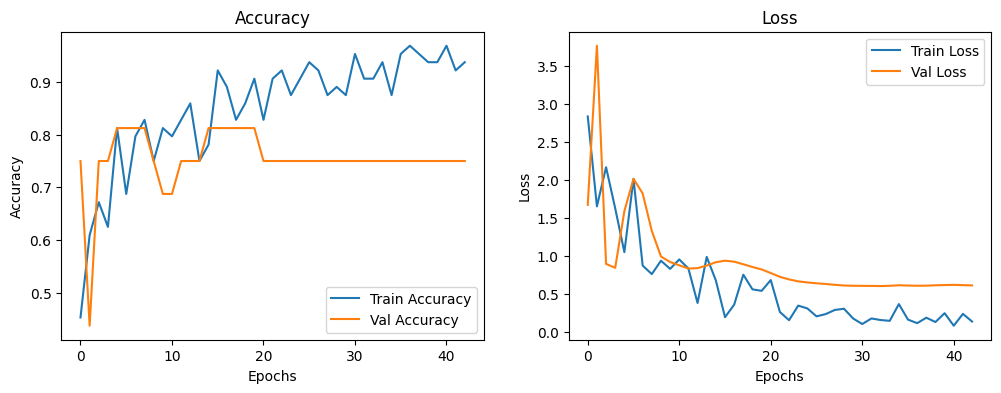

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediction: NonPhishing


/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize


In [1]:
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Set the target size for the spectrograms (128 mel bands, fixed number of time frames)
TARGET_TIME_FRAMES = 300  # Adjust based on average spectrogram length

# Function to pad or truncate mel spectrograms to a fixed size
def pad_or_truncate(mel_spect, target_frames):
    if mel_spect.shape[1] < target_frames:
        # Pad with zeros if the spectrogram is shorter than the target length
        pad_width = target_frames - mel_spect.shape[1]
        mel_spect = np.pad(mel_spect, ((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncate if the spectrogram is longer than the target length
        mel_spect = mel_spect[:, :target_frames]
    return mel_spect

# Function to convert audio file to a mel spectrogram
def audio_to_mel_spectrogram(file_path, n_mels=128):
    y, sr = librosa.load(file_path, duration=5.0)  # Load with fixed duration
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect_db = pad_or_truncate(mel_spect_db, TARGET_TIME_FRAMES)
    return mel_spect_db

# Load all audio files and convert them to mel spectrograms
def load_data(folder_path):
    X = []
    y = []
    for label in ['Phishing', 'NonPhishing']:
        label_folder = os.path.join(folder_path, label)
        for file in os.listdir(label_folder):
            if file.endswith('.mp3') or file.endswith('.wav'):
                file_path = os.path.join(label_folder, file)
                mel_spect = audio_to_mel_spectrogram(file_path)
                X.append(mel_spect)
                y.append(label)
    return np.array(X), np.array(y)

# Load the dataset
X, y = load_data('PhishingVoiceDataset')

# Preprocess the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normalize the data
X = X[..., np.newaxis]  # Add channel dimension for CNN
X = X / np.max(X)  # Normalize input data

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Build the CNN model
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))  # 2 classes: Phishing and NonPhishing

    return model

# Create the model
input_shape = X_train.shape[1:]  # Get the input shape from training data
model = create_cnn_model(input_shape)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model
model.save('phishing_detection_model.h5')

# Function to make predictions on new audio files
def predict(file_path):
    mel_spect = audio_to_mel_spectrogram(file_path)
    mel_spect = mel_spect[..., np.newaxis]
    mel_spect = mel_spect / np.max(mel_spect)  # Normalize
    mel_spect = np.expand_dims(mel_spect, axis=0)  # Add batch dimension
    prediction = model.predict(mel_spect)
    predicted_class = le.inverse_transform([np.argmax(prediction)])
    return predicted_class[0]

# Example prediction
example_file = 'n1.mp3'
print("Prediction:", predict(example_file))


In [2]:
import os

# Function to make predictions on multiple audio files in a directory
def predict_on_directory(directory_path):
    predictions = []
    for file in os.listdir(directory_path):
        if file.endswith('.mp3') or file.endswith('.wav'):
            file_path = os.path.join(directory_path, file)
            predicted_class = predict(file_path)
            predictions.append((file, predicted_class))
            print(f"File: {file}, Prediction: {predicted_class}")
    return predictions

# Example usage for batch prediction
directory_path = 'mnt'  # Update this to your folder containing test audio files
predictions = predict_on_directory(directory_path)

# Print the results
for file, prediction in predictions:
    print(f'File: {file}, Prediction: {prediction}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
File: n5.mp3, Prediction: NonPhishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
File: p1.mp3, Prediction: Phishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize


File: n4.mp3, Prediction: NonPhishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
File: n3.mp3, Prediction: NonPhishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
File: p4.mp3, Prediction: NonPhishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize


File: p3.mp3, Prediction: NonPhishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
File: p5.mp3, Prediction: NonPhishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: p2.mp3, Prediction: NonPhishing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: divide by zero encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize
/tmp/ipykernel_241224/2592829259.py:140: RuntimeWarning: invalid value encountered in divide
  mel_spect = mel_spect / np.max(mel_spect)  # Normalize


File: n2.mp3, Prediction: NonPhishing
File: n5.mp3, Prediction: NonPhishing
File: p1.mp3, Prediction: Phishing
File: n4.mp3, Prediction: NonPhishing
File: n3.mp3, Prediction: NonPhishing
File: p4.mp3, Prediction: NonPhishing
File: p3.mp3, Prediction: NonPhishing
File: p5.mp3, Prediction: NonPhishing
File: p2.mp3, Prediction: NonPhishing
File: n2.mp3, Prediction: NonPhishing
